In [4]:
!pip install csbdeep
!pip install stardist
!pip install git+https://github.com/stardist/augmend.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 6.6 MB/s 
     |████████████████████████████████| 2.9 MB 51.8 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 26.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/stardist/augmend.git to /tmp/pip-req-build-brf2ucdj
  Running command git clone -q https://github.com/stardist/augmend.git /tmp/pip-req-build-brf2ucdj
  Created wheel for augmend: filename=augmend-0.1.0-py3-none-any.whl size=17336 sha256=e8c0e6fa84b7391ad4e2233c59d7d17995c3fa4dee503a0e0eb2fa2b4cb3ac1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-q9fsh

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
option = '2d' #'3d'
if option == '3d':
    data_training = "/mnt/tronador/jupyter/training_dataset/pancreas_3D/train"
    data_testing = "/mnt/tronador/jupyter/training_dataset/pancreas_3D/test"
    dest_path = "/mnt/tronador/jupyter/jupyter-labs/training_pancreas_data"
    model_name = 'stardist_pancreas_2022_03_21'
    n_channel = 1
    axis_norm = (0,1,2)
    n_dim = 3
    axis_augmentation = (1,2)
else:
    data_training = "/content/drive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_embryo/training_data"
    data_testing = "/content/drive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_embryo/testing_data"
    dest_path = "/content/drive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_embryo"
    model_name = 'stardist_embryos_2d_2022_03_21'
    n_channel = 1
    axis_norm = (0,1)
    n_dim = 2
    axis_augmentation = (0,1)
    IMG_HEIGHT = 256
    IMG_WIDTH = 256

In [5]:
from __future__ import print_function, unicode_literals, absolute_import, division

## Libraries for files management and mathematical operations

import numpy as np
import time, os, sys
import numpy as np
from tqdm import tqdm # for displaying a progression bar
from glob import glob # recursive search of files or folder based on a specific pattern
# import wget
from urllib.parse import urlparse

## Libraries for displaying images and plotting graphs 

import matplotlib
matplotlib.rcParams["image.interpolation"] = None
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Libraries for image management and manipulaption

from tifffile import imread, imwrite # handle tif file format
import skimage.io

## Specific libraries for Deep Learning and image segmentation

from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from augmend import Augmend, FlipRot90, Elastic, Identity, IntensityScaleShift, AdditiveNoise, Scale

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist import fill_label_holes, calculate_extents, gputools_available, Rays_GoldenSpiral
from stardist.matching import matching, matching_dataset

if option == '3d':
    from stardist.models import StarDist3D, Config3D
else:
    from stardist.models import Config2D, StarDist2D, StarDistData2D


np.random.seed(6)
lbl_cmap = random_label_cmap()

print('importing libraries done')

importing libraries done


In [6]:
def get_data(file_list):
    file_list = sorted(file_list)
    im_list = list(map(imread,file_list))
    return im_list

In [7]:
# load the raw images for the training
X = get_data(glob(os.path.join(data_training, 'raw', '*.tif')))
print(f'number of training raw images found : {len(X)}')
# for file in file_list : print(f'{os.path.basename(file)} - image size : {imread(file).shape}') 

# load the label images
Y = get_data(glob(os.path.join(data_training, 'label_class', '*.tif')))
print(f'number of training label images found : {len(Y)}')
# for file in file_list : print(f'{os.path.basename(file)} - image size : {imread(file).shape}') 

# load the raw images for the training
X_test = get_data( glob(os.path.join(data_testing, 'raw', '*.tif')))
print(f'number of training raw images found : {len(X_test)}')
# for file in file_list : print(f'{os.path.basename(file)} - image size : {imread(file).shape}') 

# load the label images
Y_test = get_data(glob(os.path.join(data_testing, 'label_class', '*.tif')))
print(f'number of training label images found : {len(Y_test)}')
# for file in file_list : print(f'{os.path.basename(file)} - image size : {imread(file).shape}') 

number of training raw images found : 117
number of training label images found : 117
number of training raw images found : 27
number of training label images found : 27


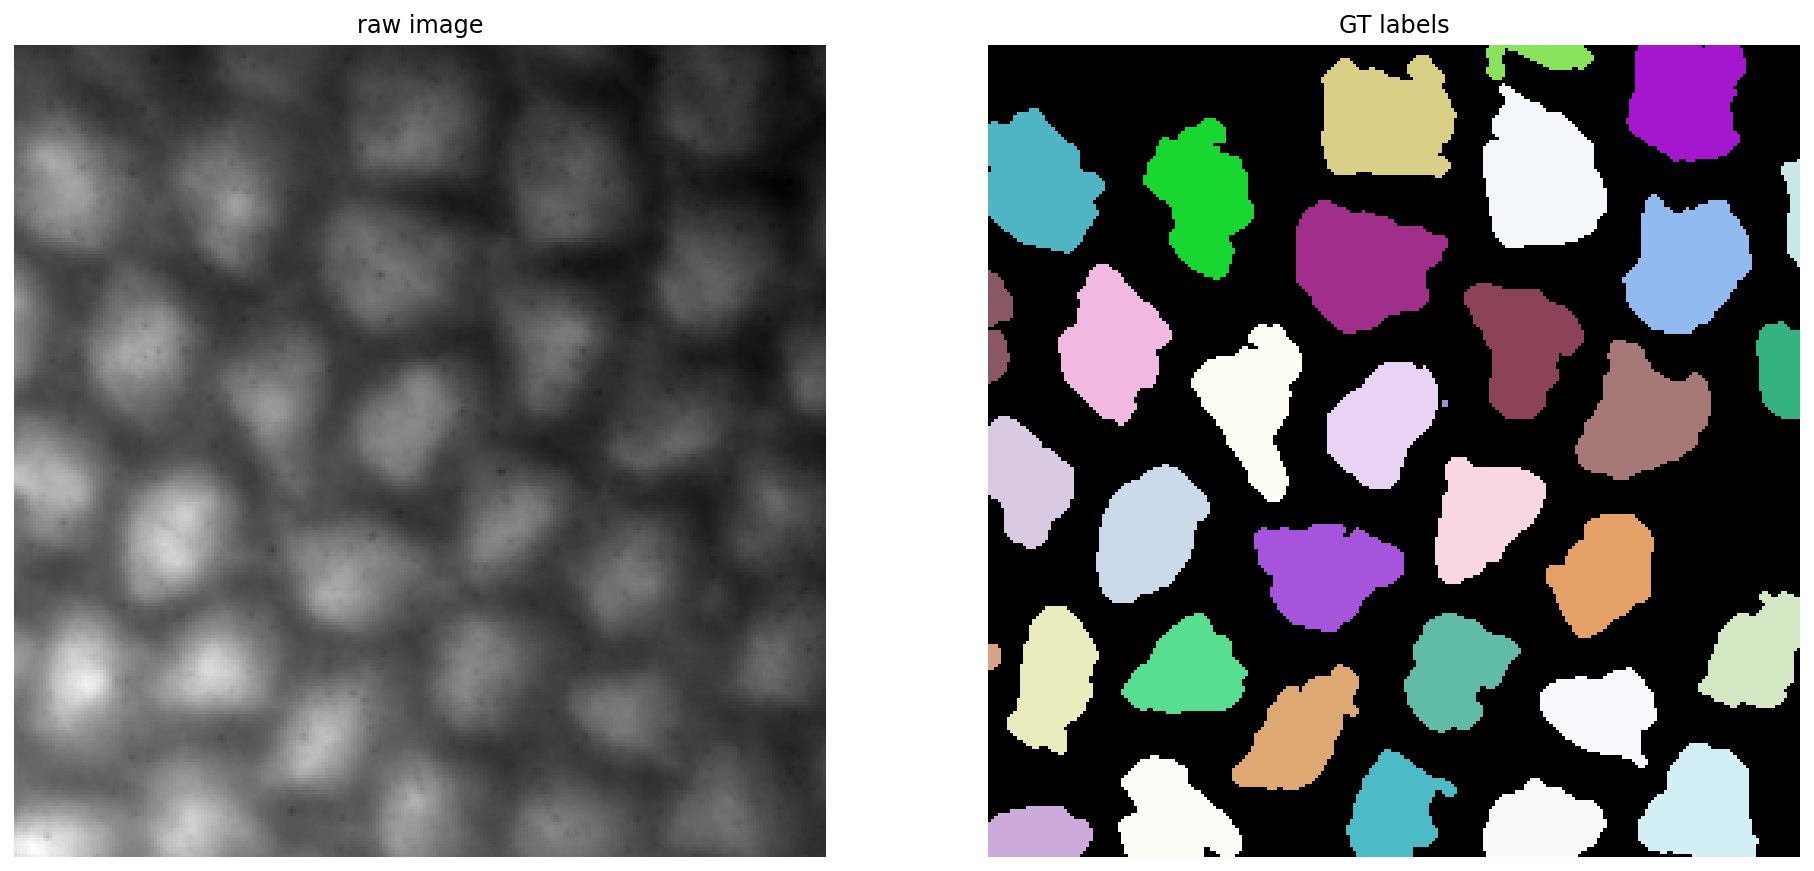

In [9]:
# select an image from the loaded data
n_im = np.random.randint(0, len(X)-1)
raw, lbl = X[n_im], Y[n_im]

if option == '3d':
    # plot the xy-MIP of the raw image and its associated label image
    plt.figure(figsize=(16,10))
    plt.subplot(121); plt.imshow(np.max(raw,axis=0),cmap='gray')
    plt.axis('off'); plt.title('MIP of raw image (XY slice)')
    plt.subplot(122); plt.imshow(np.max(lbl, axis=0),cmap=lbl_cmap)
    plt.axis('off'); plt.title('GT labels (XY slice)')

    # plot the xz-MIP of the raw image and its associated label image
    plt.figure(figsize=(16,10))
    plt.subplot(121); plt.imshow(np.max(raw,axis=1),cmap='gray')
    plt.axis('off'); plt.title('MIP of raw image (XZ slice)')
    plt.subplot(122); plt.imshow(np.max(lbl, axis=1),cmap=lbl_cmap)
    plt.axis('off'); plt.title('GT labels (XZ slice)')

else:
    # plot a raw image and its associated label
    plt.figure(figsize=(16,10))
    plt.subplot(121); plt.imshow(raw,cmap='gray')
    plt.axis('off'); plt.title('raw image')
    plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap)
    plt.axis('off'); plt.title('GT labels')

None;

In [10]:
X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
# Y = [fill_label_holes(y) for y in tqdm(Y)]

X_test = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X_test)]
# Y_test = [fill_label_holes(y) for y in tqdm(Y_test)]

100%|██████████| 27/27 [00:00<00:00, 738.04it/s]


In [11]:
# compute the anisotropy of the label objects
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('Empirical anisotropy of labeled objects = %s' % str(anisotropy))

# compute the min dimensions of the training set
im_dim = np.zeros((len(X), n_dim))
for n,im in enumerate(X):
    im_dim[n,:] = im.shape
print(f'The smallest dimensions of the training set are : {np.min(im_dim, axis=0)}')

# compute the median size of the nuclei
median_size = calculate_extents(Y, np.median)
print(f"Median object size:      {median_size}")

Empirical anisotropy of labeled objects = (1.0, 1.0)
The smallest dimensions of the training set are : [256. 256.]
Median object size:      [34. 34.]


In [12]:
# 96 is a good default choice for anisotropic 3D data (see 1_data.ipynb) - 32 is usually fine for anisotropic 2D data
if option == '3d':
    n_rays = 96
    train_patch_size = (28,128,128)
else:
    n_rays = 32
    train_patch_size = (128,128)

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = tuple(1 if a > 1.5 else 4 for a in anisotropy)

if option == '3d':
    
    # Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
    rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)
    conf = Config3D (
        rays             = rays,
        grid             = grid,
        anisotropy       = anisotropy,
        use_gpu          = use_gpu,
        n_channel_in     = 1,
        # adjust for your data below (make patch size as large as possible)
        train_patch_size = train_patch_size,
        train_batch_size = 2,
        backbone = 'unet',
        train_epochs = 1,
        train_steps_per_epoch = 100
    )
else:
    conf = Config2D (
        n_rays             = n_rays,
        grid             = grid,
        use_gpu          = use_gpu,
        n_channel_in     = 1,
        # adjust for your data below (make patch size as large as possible)
        train_patch_size = train_patch_size,
        train_batch_size = 2,
        backbone = 'unet',
        train_epochs = 50,
        train_steps_per_epoch = 100
    )
vars(conf)

{'axes': 'YXC',
 'backbone': 'unet',
 'grid': (4, 4),
 'n_channel_in': 1,
 'n_channel_out': 33,
 'n_classes': None,
 'n_dim': 2,
 'n_rays': 32,
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_background_reg': 0.0001,
 'train_batch_size': 2,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_class_weights': (1, 1),
 'train_completion_crop': 32,
 'train_dist_loss': 'mae',
 'train_epochs': 50,
 'train_foreground_only': 0.9,
 'train_learning_rate': 0.0003,
 'train_loss_weights': (1, 0.2),
 'train_n_val_patches': None,
 'train_patch_size': (128, 128),
 'train_reduce_lr': {'factor': 0.5, 'min_delta': 0, 'patience': 40},
 'train_sample_cache': True,
 'train_shape_completion': False,
 'train_steps_per_epoch': 100,
 'train_tensorboard': True,
 'unet_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_kernel_size': (3, 3),
 

In [13]:
# create the folder if it does not exist yet
if not os.path.exists(dest_path):
    os.mkdir(dest_path)
    print(f"folder {dest_path} created!")

# based on the parameters defined above, create the StarDist model
model_folder = os.path.join(dest_path, model_name)
if option == '3d':
    model = StarDist3D(conf, name=model_name, basedir=model_folder)
else:
    model = StarDist2D(conf, name=model_name, basedir=model_folder)

base_model.py (149): output path for model already exists, files may be overwritten: /content/drive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_embryo/stardist_embryos_2d_2022_03_21/stardist_embryos_2d_2022_03_21


Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [14]:
median_size = calculate_extents(Y, np.median)
if option == '3d':
    fov = np.array(model._axes_tile_overlap('ZYX'))
else:
    fov = np.array(model._axes_tile_overlap('YX'))
    
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [34. 34.]
network field of view :  [180 181]


In [15]:
elastic_kwargs = dict(axis=axis_augmentation, amount=10, use_gpu=model.config.use_gpu)
#scale_kwargs = dict(axis=1, amount=1.5, use_gpu=model.config.use_gpu)
aug = Augmend()
#aug.add([Scale(order=0,**scale_kwargs),Scale(order=0,**scale_kwargs)], probability=0.25)
aug.add([FlipRot90(axis=axis_augmentation),FlipRot90(axis=axis_augmentation)])
aug.add([Elastic(order=0,**elastic_kwargs),Elastic(order=0,**elastic_kwargs)], probability=0.5)
aug.add([IntensityScaleShift(scale=(.6,2),shift=(-.2,.2)),Identity()])
aug.add([AdditiveNoise(sigma=(0.05,0.05)),Identity()], probability=0.25)

def augmenter(x,y):
    return aug([x,y])

In [16]:
model.train(X, Y, validation_data=(X_test,Y_test), augmenter=augmenter)

Epoch 1/50
Cause: Unable to locate the source code of <function _gcd_import at 0x7f4766f45b00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function _gcd_import at 0x7f4766f45b00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the funct

In [17]:
model.optimize_thresholds(X_test, Y_test)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:05<00:01,  2.69it/s, 0.471 -> 0.737]


Using optimized values: prob_thresh=0.471473, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'nms': 0.3, 'prob': 0.47147300319271124}

In [18]:
# using the newly trained model, calculate the segmentation prediction using the test images
Y_test_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_test)]

100%|██████████| 27/27 [00:01<00:00, 14.81it/s]


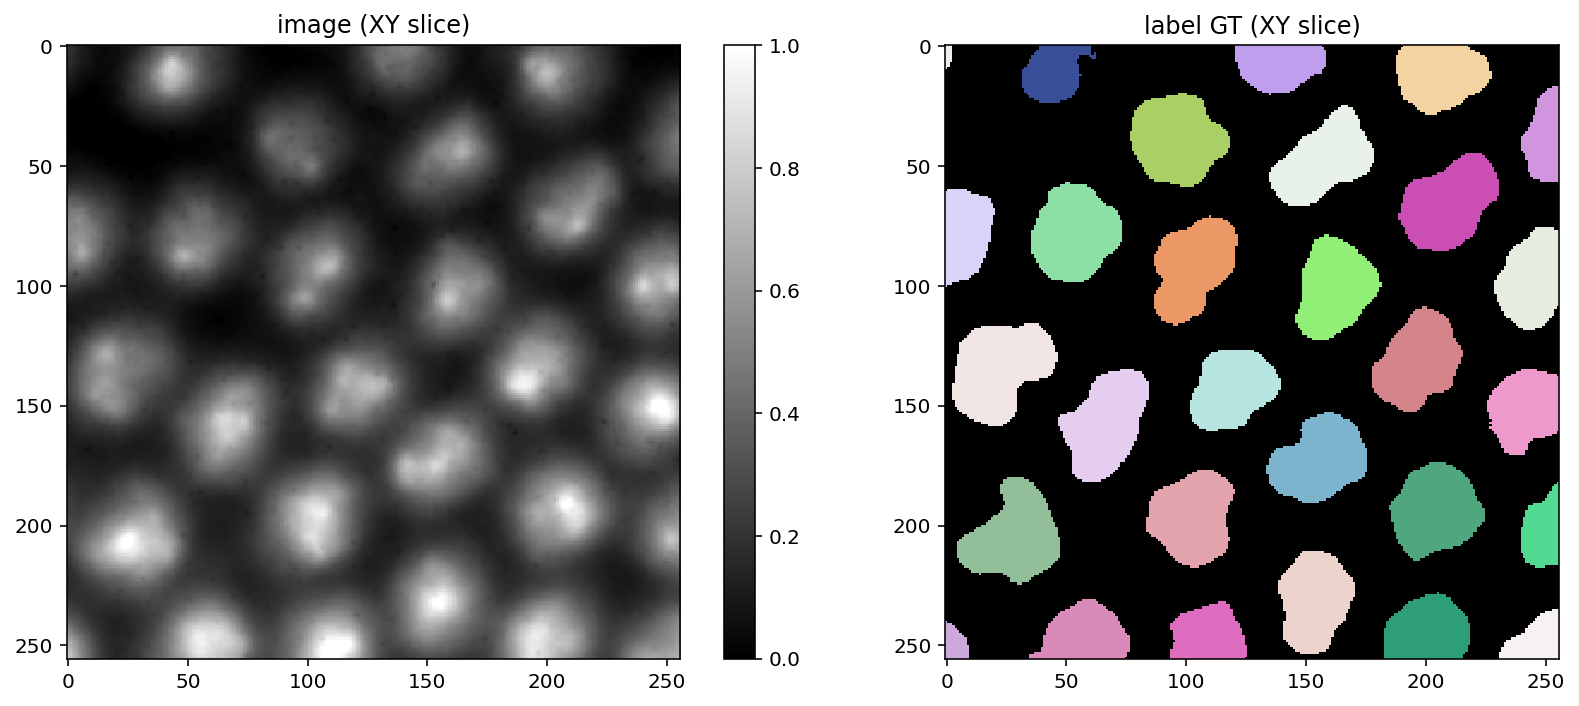

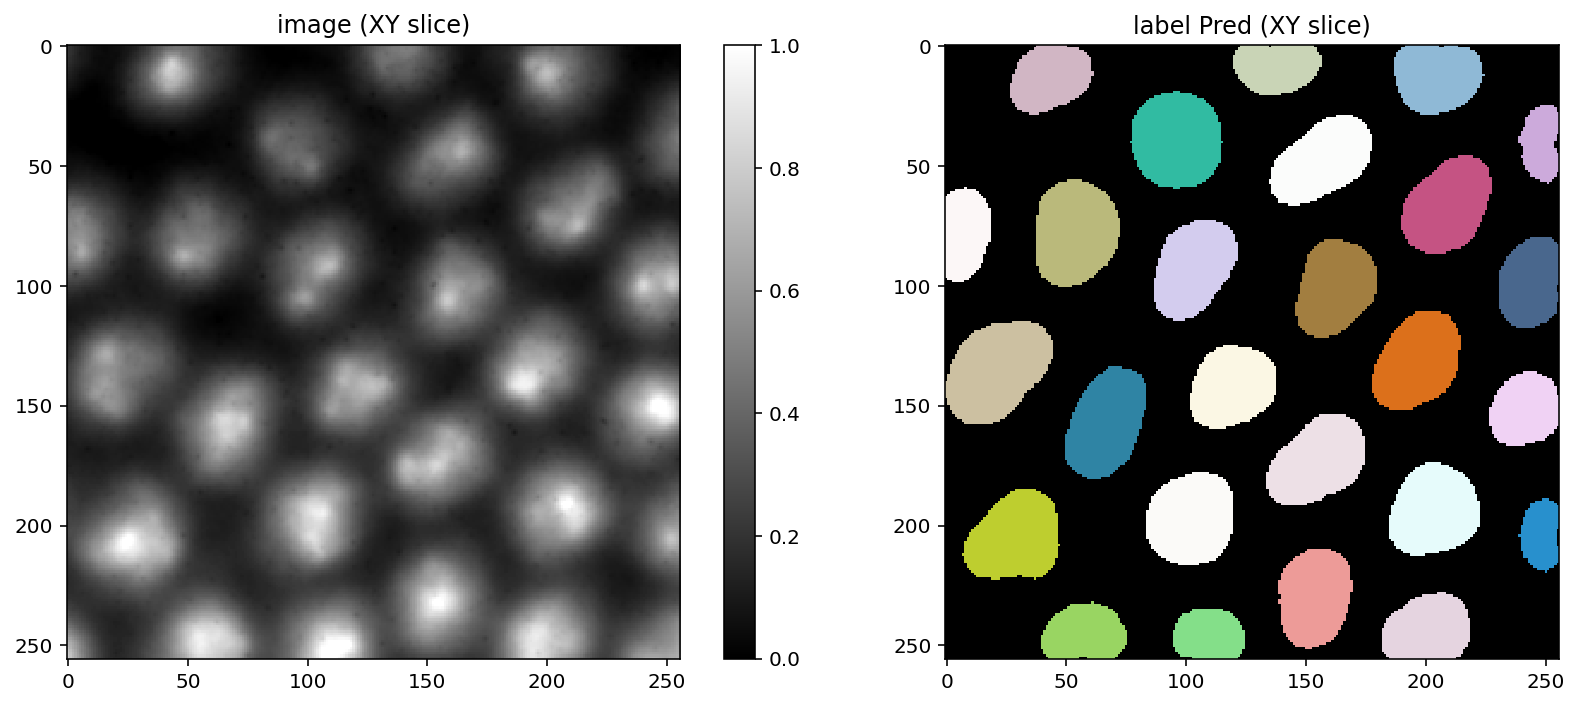

In [20]:
def plot_img_label(img, lbl, img_title="image (XY slice)", lbl_title="label (XY slice)", **kwargs):
    
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    if len(img.shape) == 3:
        im = ai.imshow(np.max(img, axis=0), cmap='gray', clim=(0,1))
    else:
        im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    if len(img.shape) == 3:
        al.imshow(np.max(lbl, axis=0), cmap=lbl_cmap)
    else:
        al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

n_image = np.random.randint(0, len(X_test)-1)
plot_img_label(X_test[n_image],Y_test[n_image], lbl_title="label GT (XY slice)")
plot_img_label(X_test[n_image],Y_test_pred[n_image], lbl_title="label Pred (XY slice)")

100%|██████████| 9/9 [00:01<00:00,  6.95it/s]


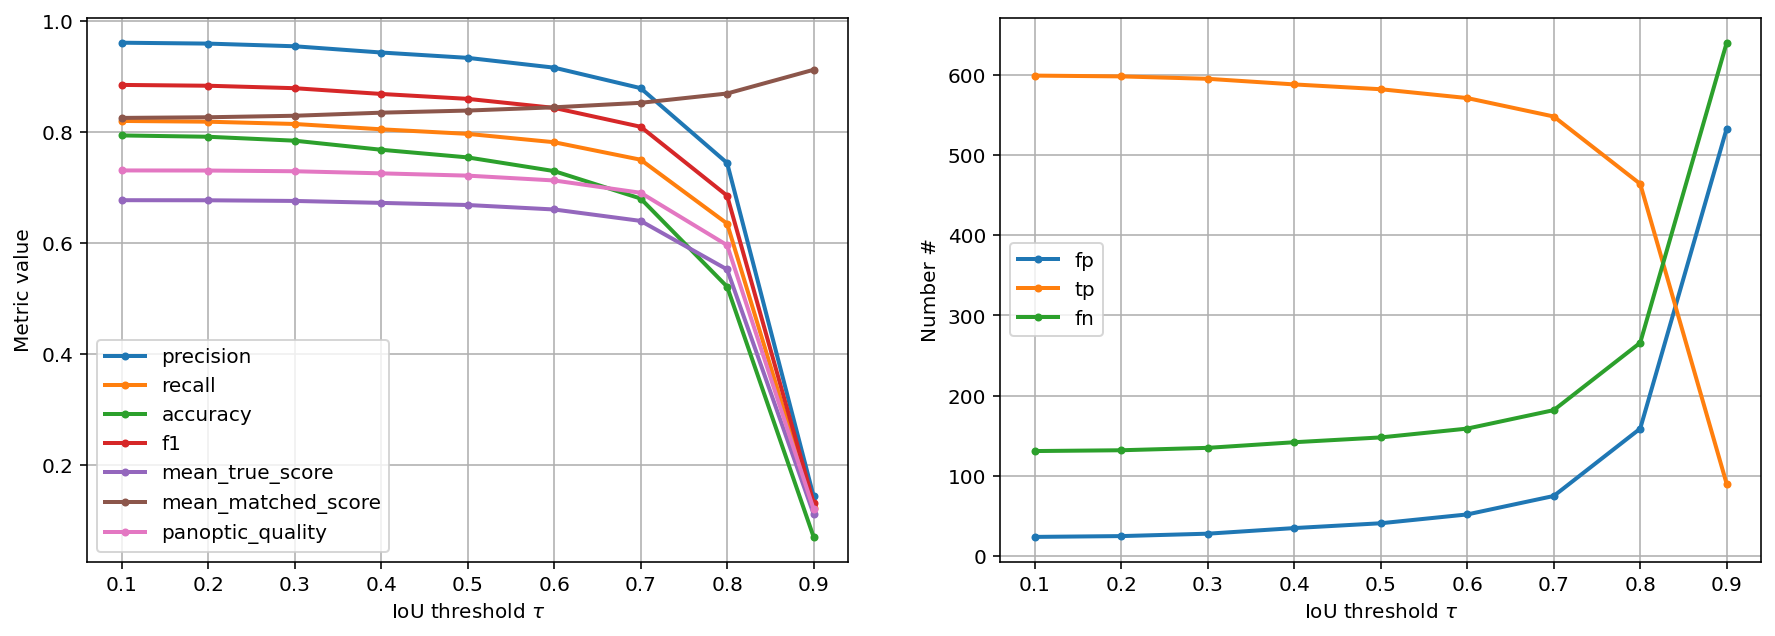

In [21]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_test, Y_test_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();